In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


--2022-04-27 14:00:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   111MB/s    in 0.6s    

2022-04-27 14:00:20 (111 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import zipfile

# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
import os

base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'validation', 'vectorize.py']

Contents of train directory:
['dogs', 'cats']

Contents of validation directory:
['dogs', 'cats']


In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.392.jpg', 'cat.708.jpg', 'cat.655.jpg', 'cat.119.jpg', 'cat.4.jpg', 'cat.987.jpg', 'cat.487.jpg', 'cat.20.jpg', 'cat.835.jpg', 'cat.302.jpg']
['dog.339.jpg', 'dog.172.jpg', 'dog.823.jpg', 'dog.972.jpg', 'dog.663.jpg', 'dog.356.jpg', 'dog.95.jpg', 'dog.347.jpg', 'dog.413.jpg', 'dog.184.jpg']


In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

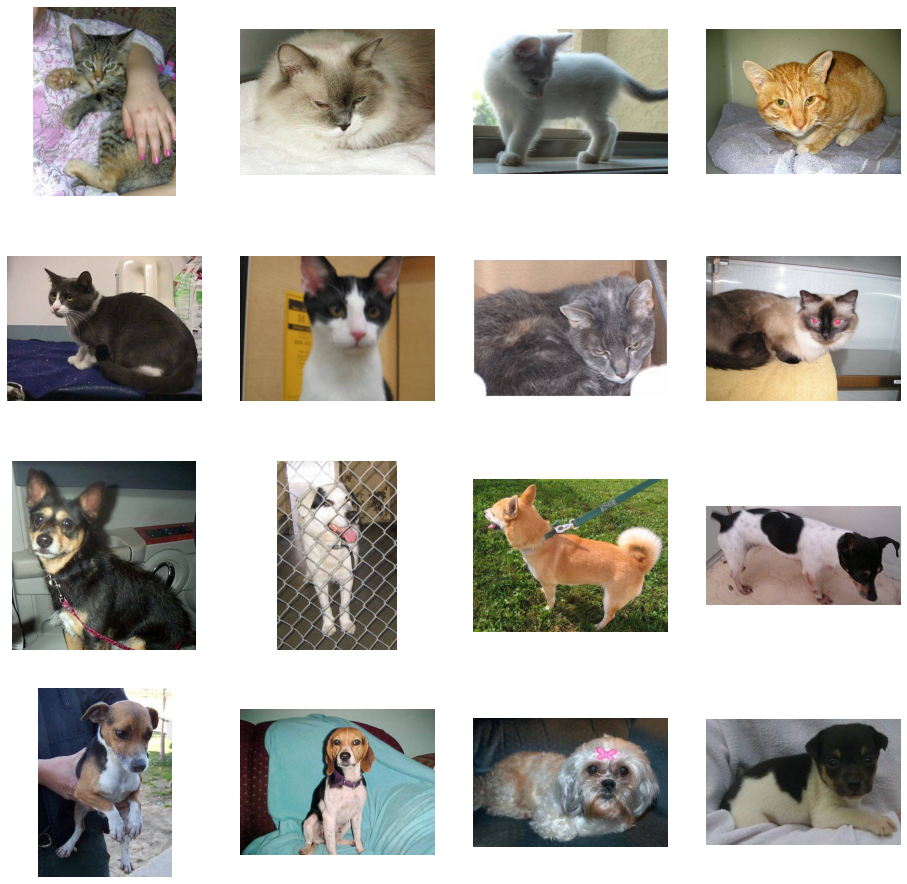

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=50,
            verbose=2
            )

Epoch 1/15
100/100 - 24s - loss: 0.7591 - accuracy: 0.5650 - val_loss: 0.6755 - val_accuracy: 0.6430 - 24s/epoch - 237ms/step
Epoch 2/15
100/100 - 10s - loss: 0.6488 - accuracy: 0.6425 - val_loss: 0.6341 - val_accuracy: 0.6320 - 10s/epoch - 103ms/step
Epoch 3/15
100/100 - 10s - loss: 0.5687 - accuracy: 0.7205 - val_loss: 0.5674 - val_accuracy: 0.7120 - 10s/epoch - 103ms/step
Epoch 4/15
100/100 - 10s - loss: 0.4634 - accuracy: 0.7875 - val_loss: 0.6298 - val_accuracy: 0.7000 - 10s/epoch - 102ms/step
Epoch 5/15
100/100 - 10s - loss: 0.3664 - accuracy: 0.8385 - val_loss: 0.6597 - val_accuracy: 0.7230 - 10s/epoch - 102ms/step
Epoch 6/15
100/100 - 10s - loss: 0.2726 - accuracy: 0.8805 - val_loss: 0.6029 - val_accuracy: 0.7300 - 10s/epoch - 102ms/step
Epoch 7/15
100/100 - 10s - loss: 0.1881 - accuracy: 0.9290 - val_loss: 0.7757 - val_accuracy: 0.7480 - 10s/epoch - 101ms/step
Epoch 8/15
100/100 - 10s - loss: 0.1317 - accuracy: 0.9535 - val_loss: 0.9252 - val_accuracy: 0.7390 - 10s/epoch - 101

In [14]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


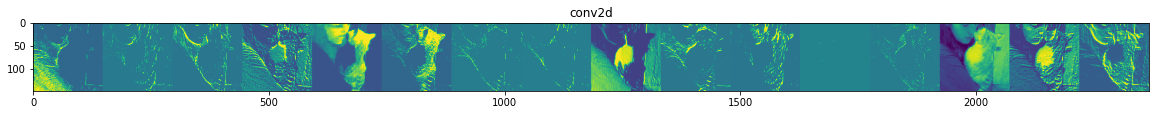

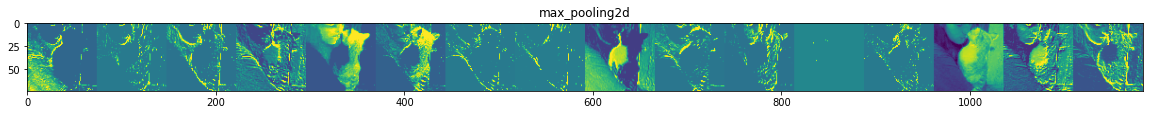

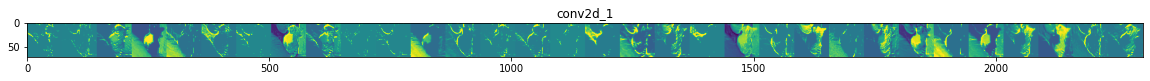

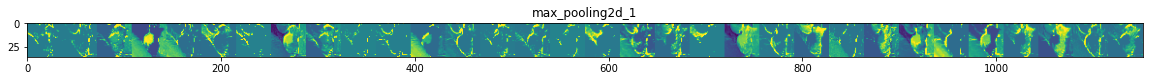

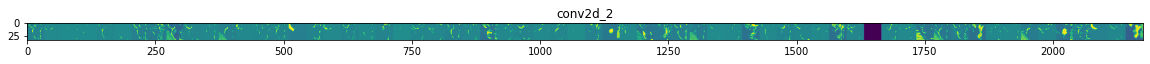

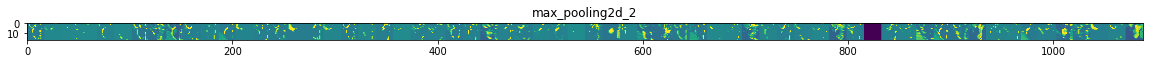

In [15]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

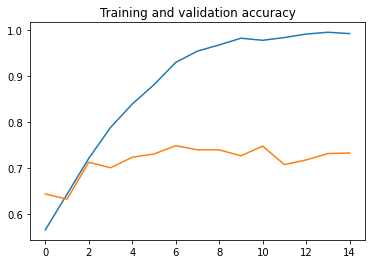

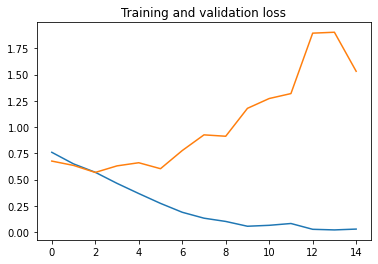

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )